# Aurora Image Classification

In [19]:
import glob
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import sys

from random import randint
from spacepy import pycdf
from PIL import Image, ImageOps

## Get Image Data from CDF and convert to PNG files

In [16]:
# Example of data, which are time series of images (pixels) in NASA's CDF format
cdf = pycdf.CDF("data/asf/thg_l1_asf_fsmi_2008020203_v01.cdf")
print(cdf)
cdf.close()

range_epoch: CDF_EPOCH [2]
thg_asf_fsmi: CDF_UINT2 [1200, 256, 256]
thg_asf_fsmi_column: CDF_UINT2 [256] NRV
thg_asf_fsmi_epoch: CDF_EPOCH [1200]
thg_asf_fsmi_epoch0: CDF_EPOCH [] NRV
thg_asf_fsmi_row: CDF_UINT2 [256] NRV
thg_asf_fsmi_tend: CDF_REAL8 [1200]
thg_asf_fsmi_time: CDF_REAL8 [1200]


In [13]:
def process_images(images):
    processed_images = []
    for image in images:
        processed_image = image - np.percentile(image, 1)
        processed_image = processed_image / np.percentile(image, 99)
        processed_image = np.maximum(np.zeros(processed_image.shape), processed_image)
        processed_image = np.minimum(np.ones(processed_image.shape), processed_image)
        processed_images.append(processed_image)
    return np.array(processed_images)

In [14]:
def create_png_files(directory, pixels, times):
    images = process_images(pixels)
    
    if not os.path.exists(directory):
        os.mkdir(directory)
    
    for image, time in zip(images, times):
        time_str = time.strftime('%Y%m%d%H%M%S')
        
        image = (image * 255).astype(np.uint8)
                
        im = Image.fromarray(image)
                
        im = ImageOps.grayscale(im)
        
        im.save(f'{directory}/{time_str}.png')

In [20]:
cdf_files = [f for f in os.listdir("data/asf") if not f.startswith('.')]

In [21]:
i = 0
for file in cdf_files:
    i += 1
    sys.stdout.write(f"\r{i}/{len(cdf_files)}: {file}")
    cdf = pycdf.CDF("data/asf/" + file)
    cdf_dat = cdf.copy()
    images = np.array(cdf_dat['thg_asf_fsmi'])
    times = np.array(cdf_dat['thg_asf_fsmi_epoch'])
    create_png_files("data/png", images, times)
    cdf.close()

100/100: thg_l1_asf_fsmi_2008022409_v01.cdf

## Use TAME Classifier on PNG Files

In [6]:
sys.path.append(os.path.abspath("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/"))
sys.path.append(os.path.abspath("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/tame/dataHandler"))
from dataHandler import AsimClassifier
torch_data_location = "tame/data/torch/"
clf = AsimClassifier(torch_path=torch_data_location)
image_files = glob.glob("data/png/*.png")

In [7]:
results = clf.classify_images(image_files)

2023-04-03 19:15:32,563 - logger - INFO - Device set to cpu
2023-04-03 19:15:32,564 - logger - INFO - loading pretrained torchvision model
2023-04-03 19:15:32,593 - logger - INFO - Extracting features


 |==================================================| 100.000% 


In [9]:
results['time'] = results['file'].apply(lambda x: int(re.findall(r'([\d]+)\.png$', x)[0])).sort_values()
results = results.sort_values('time')
results['datetime'] = results['time'].apply(lambda x: pd.to_datetime(str(x)))
results = results.reset_index(drop=True)

Saved to:  data/aurora_classification.csv


In [11]:
results.to_csv("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/data/aurora_classification.csv", index=False, encoding="utf-8-sig")
print("Saved to: ", "/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/data/aurora_classification.csv")
results

Saved to:  /Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/data/aurora_classification.csv


,file,pred,class_0,class_1,class_2,class_3,class_4,class_5,feat_0,feat_1,...,feat_992,feat_993,feat_994,feat_995,feat_996,feat_997,feat_998,feat_999,time,datetime
0,data/png/20080201050000.png,1,0.317789,0.556873,0.034154,0.053034,0.002217,0.035933,0.294873,1.470107,...,0.546924,0.353477,0.687410,-0.747113,-1.639140,2.395277,-3.171072,-2.887594,20080201050000,2008-02-01 05:00:00
1,data/png/20080201050003.png,1,0.382069,0.493313,0.042183,0.044010,0.001950,0.036474,0.084170,1.719256,...,0.693903,0.814302,0.971467,-0.550387,-1.534633,2.586737,-3.023072,-2.550165,20080201050003,2008-02-01 05:00:03
2,data/png/20080201050006.png,1,0.275734,0.621795,0.027743,0.031072,0.001119,0.042537,0.290627,1.459680,...,0.923179,0.982765,0.988543,-0.497707,-1.581259,2.673326,-3.013569,-2.907217,20080201050006,2008-02-01 05:00:06
3,data/png/20080201050009.png,1,0.276209,0.625125,0.034895,0.030952,0.001016,0.031801,0.194023,1.511003,...,0.646145,1.114186,0.926287,-0.581321,-1.708554,2.412990,-3.014352,-2.463159,20080201050009,2008-02-01 05:00:09
4,data/png/20080201050012.png,1,0.307386,0.606333,0.038413,0.026665,0.000845,0.020358,0.555727,1.963533,...,0.568968,1.389932,1.118883,-0.433398,-1.618578,2.110835,-2.935642,-2.437526,20080201050012,2008-02-01 05:00:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118430,data/png/20080228115945.png,3,0.000191,0.000130,0.000432,0.995553,0.003337,0.000357,-2.393983,-0.134105,...,-0.426190,-1.027114,-1.536432,-2.934641,-1.927394,0.549228,-1.927099,-3.355604,20080228115945,2008-02-28 11:59:45
118431,data/png/20080228115948.png,3,0.000018,0.000013,0.000015,0.995884,0.003719,0.000350,-2.263071,-0.359796,...,-0.522297,-1.098317,-1.323058,-3.099965,-1.971607,0.796591,-2.064235,-3.459474,20080228115948,2008-02-28 11:59:48
118432,data/png/20080228115951.png,3,0.000201,0.000118,0.000382,0.994672,0.004137,0.000490,-2.296318,-0.342114,...,-0.606188,-1.227629,-1.329903,-3.159580,-2.071197,0.466096,-1.843596,-3.410557,20080228115951,2008-02-28 11:59:51
118433,data/png/20080228115954.png,3,0.000017,0.000012,0.000014,0.995577,0.004036,0.000344,-2.220871,-0.329416,...,-0.346693,-1.077765,-1.277915,-2.916974,-1.875651,0.550895,-1.924596,-3.069743,20080228115954,2008-02-28 11:59:54


## Data Visualization

In [4]:
results = pd.read_csv("/Users/jeffreysung/Documents/Cal/ssl/substorm-prediction/data/aurora_classification.csv")

In [7]:
def plot_probabilities_over_time(results: pd.DataFrame, time_range: list):
    """Plot probability of image to be a certain class over specified time range.

    Arguments:
    results - pandas DataFrame of classifier results
    time_range - 2 item list of times in YYYYMMDDHHMMSSMM format (EX: 20080228115945)
    """
    start = time_range[0]
    end = time_range[1]
    results = results[results['time'].between(start, end)]

    start = str(start)
    end = str(end)

    fig = plt.figure(figsize=(24, 8))
    ax = fig.gca()
    plt.title(f"Aurora Classification Results: FSMI ASF {start[:4]}-{start[4:6]}-{start[6:8]} {start[8:10]}:{start[10:12]} - {end[:4]}-{end[4:6]}-{end[6:8]} {end[8:10]}:{end[10:12]}")
    plt.ylabel("Probability of Class")
    plt.xlabel("Time")
    plt.ylim(
        ymin=0,
        ymax=1
    )
    plt.plot(results['datetime'], results['class_0'], label='arc')
    plt.plot(results['datetime'], results['class_1'], label='diffuse')
    plt.plot(results['datetime'], results['class_2'], label='discrete')
    plt.plot(results['datetime'], results['class_3'], label='cloud')
    plt.plot(results['datetime'], results['class_4'], label='moon')
    plt.plot(results['datetime'], results['class_5'], label='clear')
    ax.set_xticks(results['datetime'][::100])
    plt.xticks(rotation=45)
    plt.grid()
    plt.legend()

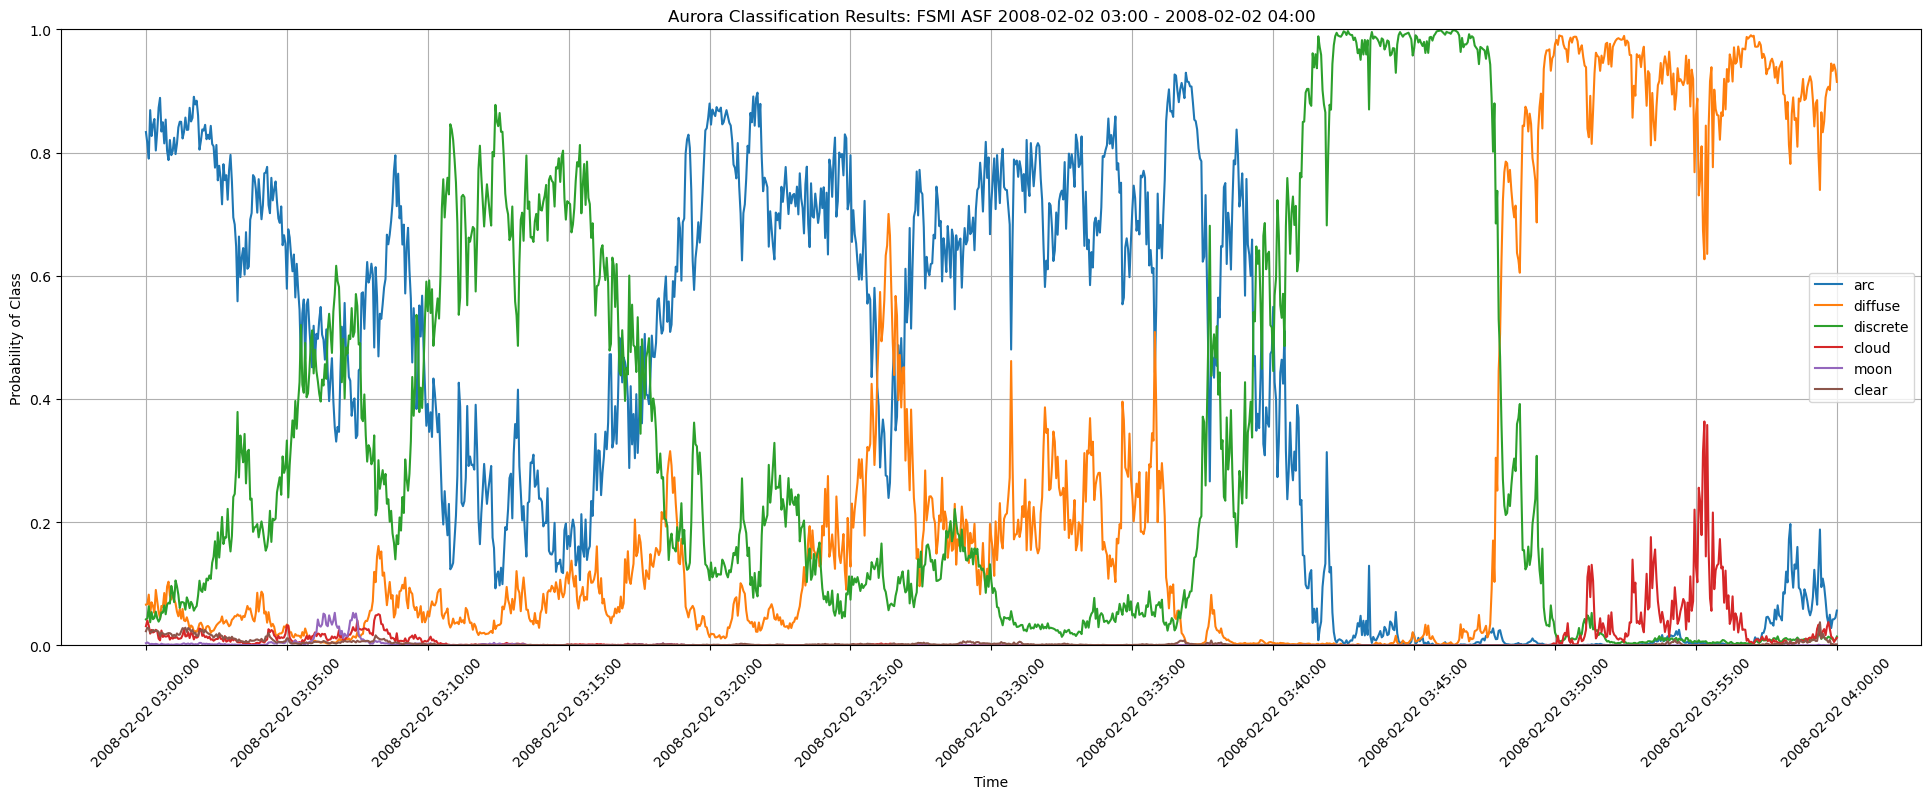

In [8]:
plot_probabilities_over_time(results, [20080202030000, 20080202040000])

In [10]:
image_files = glob.glob("data/png/*.png")

def display_single_result(image_list, results, index):
    im = Image.open(image_list[index])
    plt.imshow(im, cmap='gray')
    plt.xticks(())
    plt.yticks(())
    class_probabilities = [str(results.iloc[index]["class_"+str(i)]*100) for i in range(6)]
    print(str(results.iloc[index]['datetime']))
    print("Probabilities:")
    print("arc: " + class_probabilities[0] + "%")
    print("diffuse: " + class_probabilities[1] + "%")
    print("discrete: " + class_probabilities[2] + "%")
    print("cloud: " + class_probabilities[3] + "%")
    print("moon: " + class_probabilities[4] + "%")
    print("clear sky: " + class_probabilities[5] + "%")

2008-02-03 08:53:51
Probabilities:
arc: 80.03326913041549%
diffuse: 9.2768977612287%
discrete: 9.1472585568513%
cloud: 0.058486475035705705%
moon: 0.030659546200982823%
clear sky: 1.453428530267771%


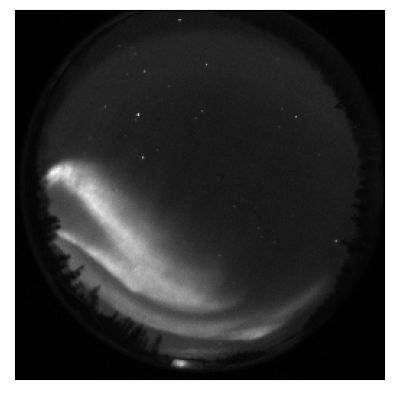

In [22]:
display_single_result(image_files, results, randint(0, 118434))